In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
from collections import namedtuple
from IPython.display import Image
%matplotlib inline

In [2]:
class Graph(object):
    def __init__(self, vertices):
        self.vertices = list(vertices)
        self.adj_list = [set() for i in range(max(vertices) + 1)]
    
    def add_edges(self, edges):
        for u, v in edges:
            self.adj_list[u].add(v)
            
    def transpose(self):
        transposed = Graph(self.vertices)
        for v in self.vertices:
            for u in self.adj_list[v]:
                transposed.adj_list[u].add(v)
        return transposed

# Coffman-Graham-Layering

Battista, Eades, Tamassia, Tollis — Graph Drawing. Algorithms for the Visualization of Graphs, p.275, Algorithm 9.1

Алгоритм реализован в точности следуя псевдокоду из книги.

Стоит заметить, что в псевдокоде из книги допущено 2 ошибки, они обнаружились в результате
несовпадения результатов работы алгоритма на примерах графов из книги.
После прочтения словесного описания работы алгоритма ошибки были исправлены.

Если абстрагироваться от запутанного научного описания, то алгоритм по сути просто топологически сортирует вершины графа,
а затем перебирает вершины графа в топологическом порядке и жадно заполняет уровни, помещая не более W вершин на каждый.

Алгоритм можно было реализовать куда более эффективно, но для этого потребовалось бы не следовать псевдокоду из книги.

In [3]:
def compute_key(v, graph, pi, inf_label):
    key = set()
    for u in graph.adj_list[v]:
        key.add(pi.get(u, inf_label))
    key = list(key)
    key.sort(reverse=True)
    return key

In [4]:
def assign_labels_to_vertices(graph):
    pi = {}
    
    inf_label = len(graph.vertices) + 1
    graphT = graph.transpose()
    
    for label in range(1, len(graph.vertices) + 1):
        candidates = []
        for v in graph.vertices:
            if v not in pi:
                candidates.append([compute_key(v, graphT, pi, inf_label), v])
        candidates.sort()
        v = candidates[0][1]
        pi[v] = label
    
    return pi

In [6]:
def CoffmanGrahamLayering(graph, W):
    pi = assign_labels_to_vertices(graph)
    
    layers = [set()]
    U = set()
    
    while len(U) < len(graph.vertices):
        u = None
        for tu in graph.vertices:
            if (tu not in U) and ((u is None) or (pi[u] < pi[tu])) and (graph.adj_list[tu] & U == graph.adj_list[tu]):
                u = tu
        
        prev_layers = set()
        for layer in layers:
            if (len(layer) < W) and (graph.adj_list[u] & prev_layers == graph.adj_list[u]):
                layer.add(u)
                break
            prev_layers |= layer
        else:
            layers.append({u})
        
        U.add(u)
    
    return layers

# Visualization

Проверена работа алгоритма на двух примерах графов из книги.

Стоит заметить, что в рамках одного уровня вершины могут меняться местами,
так как алгоритм задаёт только распределение вершин по уровням.

In [11]:
def plot_graph(graph, W, plt, labels=None, one_offset=0):
    layers = CoffmanGrahamLayering(graph, W)
    
    vxs = {}
    vys = {}
    for vy, layer in enumerate(layers):
        for vx, v in enumerate(layer):
            vxs[v] = vx + (one_offset if len(layer) == 1 else 0)
            vys[v] = vy
    
    plt.scatter([vxs[v] for v in graph.vertices], [vys[v] for v in graph.vertices], c='k')
    
    if labels is None:
        labels = map(str, graph.vertices)
    for v, label in zip(graph.vertices, labels):
        ret = plt.annotate(label, xy=[vxs[v], vys[v]], color='b')
        ret.set_path_effects([patheffects.withStroke(linewidth=2, foreground='w', alpha=0.75)])
    
    for head in graph.vertices:
        for tail in graph.adj_list[head]:
            dx = vxs[tail] - vxs[head]
            dy = vys[tail] - vys[head]
            plt.axes().arrow(vxs[head], vys[head], dx, dy, shape='full', length_includes_head=True, head_width=0.05)

### Graph sample 1

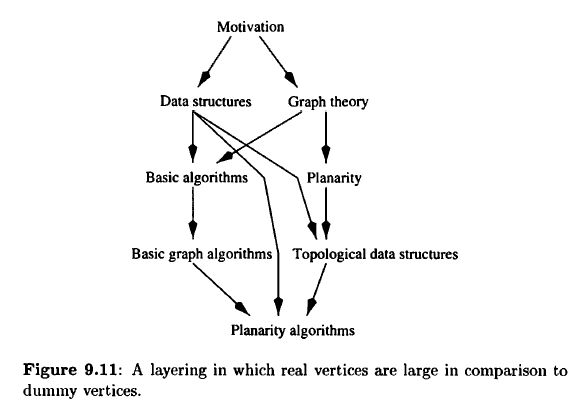

In [12]:
Image('Figure_9.11.png')

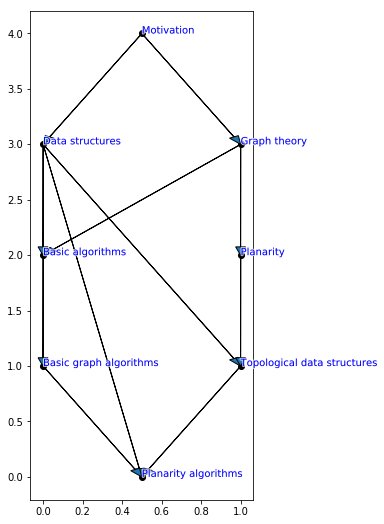

In [14]:
labels = [
    'Motivation',
    'Data structures',
    'Graph theory',
    'Basic algorithms',
    'Planarity',
    'Basic graph algorithms',
    'Topological data structures',
    'Planarity algorithms'
]

graph1 = Graph(range(1, 9))
graph1.adj_list[1] = {2, 3}
graph1.adj_list[2] = {4, 7, 8}
graph1.adj_list[3] = {4, 5}
graph1.adj_list[4] = {6}
graph1.adj_list[5] = {7}
graph1.adj_list[6] = {8}
graph1.adj_list[7] = {8}

plt.figure(figsize=(4, 9))
plot_graph(graph1, 2, plt, labels, 0.5)
plt.show()

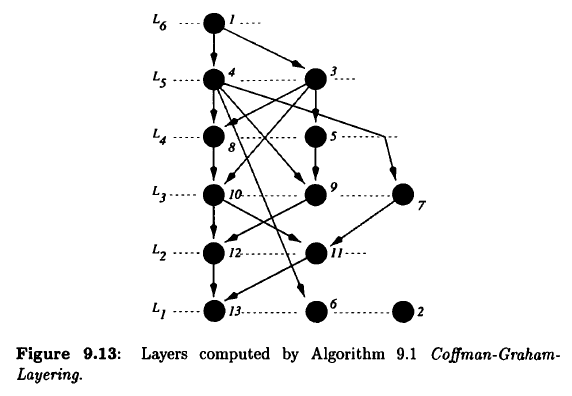

In [15]:
Image('Figure_9.13.png')

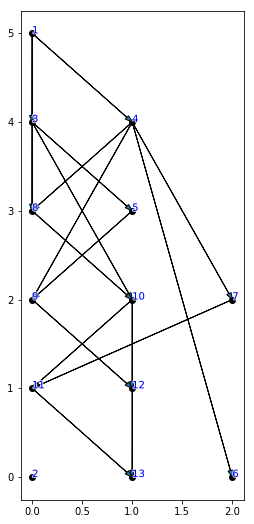

In [16]:
graph2 = Graph(range(1, 14))
graph2.adj_list[1] = {3, 4}
graph2.adj_list[3] = {5, 8, 10}
graph2.adj_list[4] = {6, 7, 8, 9}
graph2.adj_list[5] = {9}
graph2.adj_list[7] = {11}
graph2.adj_list[8] = {10}
graph2.adj_list[9] = {12}
graph2.adj_list[10] = {11, 12}
graph2.adj_list[11] = {13}
graph2.adj_list[12] = {13}

plt.figure(figsize=(4, 9))
plot_graph(graph2, 3, plt)
plt.show()